<a href="https://colab.research.google.com/github/rebeufou/Mini-Project-Data/blob/main/TD5_6_Descente_de_Gradient.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

TD5-6 : Descente de Gradient et variation
===================

L'objectif de ce TD est de coder ce que l'on a vu lors du CM3, c'est à dire, utiliser la descente de gradient pour estimer le prix d'une maison en fonction du nombre de $m^2$

Toute la première partie consiste à coder les fonctions nécessaires à l'apprentissage :
- Forward (ou prédiction) : Prend en entrée un exemple x et des poids $\theta$, qui renvoie le résultat de la régression linéaire.
- cout_mse (mse = mean square error ou moindres-carrés): C'est le critère que l'on cherche à minimiser, un bon modèle doit avoir une erreur de prédiction faible. C'est à dire que la valeur prédite doit être proche de la valeur observée (la vérité terrain)
- Fonction qui calcule le mse pour tout le dataset : permet de répondre à la question, est-ce que mon modèle est bon sur ce jeu de données ?
- Effectuer la descente de gradient pour mettre à jour les poids $\theta$ et minimiser le coût.

In [ ]:
%matplotlib inline
from utils import *
import matplotlib.pyplot as plt
import numpy as np
import time

La formule de la regression linéaire est la suivante :

$\hat{y}^{(i)} = \theta_0 + \theta_1 x^{(i)}_1 + \theta_2 x^{(i)}_2 + ... + \theta_n x^{(i)}_n$

On voit que c'est un produit vectoriel entre $\theta$ et $x^{(i)}$, enfin presque ... c’est un produit vectoriel, sauf pour $\theta_0$  
Donc, pour pouvoir utiliser le produit vectoriel et ne plus se trimballer $\theta_0$, on va utiliser une astuce :

L’idée consiste à ajouter une caractéristique supplémentaire à chaque exemple, qui contiendra toujours 1.

Avant un exemple (2 dimensions) s'écrivait : $x^{(i)} = \begin{bmatrix} 152 & 99 \end{bmatrix}$ maintenant nous l'écrirons : $x^{(i)} = \begin{bmatrix} 1 & 152 & 99\end{bmatrix}$

Complétez la fonction suivante, elle prend en entrée un jeu de données et ajoute une caractéristique qui vaut 1 à chaque exemple (Attention à ne pas utiliser de boucle !)  
La fonction doit fonctionner pour des exemples en 2D et plus.

In [ ]:
def add_one_to_dataset(dataset):
  new_dataset = np.column_stack((np.ones(dataset.shape[0]), dataset))
  return new_dataset

In [ ]:
################################## CELLULE DE TEST, VOUS AVEZ JUSTE À L’EXÉCUTER ##########################
###########################################################################################################

print("Test 2D :")
#==================
dataset, labels = create_dataset_2d(100)
#=====================================
new_dataset = add_one_to_dataset(dataset)
assert np.all(np.equal(new_dataset[:,0], np.ones(dataset.shape[0])))
assert np.all(np.equal(new_dataset[:,1], dataset[:,0]))
assert new_dataset.shape[0] == dataset.shape[0]
assert new_dataset.shape[1] == dataset.shape[1] + 1
print("2D Okay\n")

print("Test ND :")
dataset, labels = create_dataset_nd(4,int(1e7))

ref = time.time()
new_dataset = add_one_to_dataset(dataset)
taken = time.time() - ref
print("Temps mis pour ajouter les 1's : {:.2f} s (devrait prendre moins de deux secondes)".format(taken))
assert np.all(np.equal(new_dataset[:,0],np.ones(dataset.shape[0])))
assert np.all(np.equal(new_dataset[:,1],dataset[:,0]))
assert new_dataset.shape[0] == dataset.shape[0]
assert new_dataset.shape[1] == dataset.shape[1] + 1
print("Test ND okay !")

Test 2D :
2D Okay

Test ND :
Temps mis pour ajouter les 1's : 0.33 s (devrait prendre moins de deux secondes)
Test ND okay !


Désormais, on ne va plus avoir $\theta_0,\theta_1,\theta_2$ etc... mais seulement un array $\theta$ qui contiendra en premier le biais, puis les poids associé à chaque caractéristiques

$$\begin{bmatrix} \theta_0 & \theta_1 & \dots & \theta_n \end{bmatrix}$$  

Coder la fonction "forward" qui fait la prédiction pour un exemple avec les poids $\theta$ envoyés en paramètres.

Rappel de la fonction forward : $\hat{y}^i = \theta_0 + \theta_1 x^{(i)}_1 + \theta_2 x^{(i)}_2 + ... + \theta_n x^{(i)}_n$  

In [ ]:
def forward(x, theta):
  return x.dot(theta)

**Test de la fonction forward**  
Il n'y a rien à modifier, exécutez juste la cellule

In [ ]:
x = np.arange(1,4)
theta = [4,2,3]
result = forward(x,theta)

assert result == 17

x = np.array([[1,2,3,4,5,6],
              [5,2,3,4,5,6]])

theta = np.ones(6)

result = forward(x,theta)
print(result)
assert np.all(result == np.array([21, 25]))

[21. 25.]


On demande ici de calculer le coût des moindres carrés (Mean Square Error ou mse) pour tous le jeu de données.  
La fonction "mse_for_all_dataset" prend en entrée $\hat{y}$ (le résultat du modèle) et $y$ qui est la vrai réponse associée.

Pour rappel le mse s'écrit :

mse_total $= \frac{1}{n}\sum_{i=0}^{n}(\hat{y}^{(i)} - y^{(i)})^2$

In [ ]:
def mse_for_all_dataset(labels, dataset):
  som = 0
  for i in range(len(labels)):
    som += (labels[i] - dataset[i])**2
  return (som/len(labels))
 # ou return np.mean((labels[i] - dataset[i])**2)

In [ ]:
# =========== Utilisez cette cellule pour tester votre fonction mse_for_all_dataset =======
dataset = np.array([4,5,6])
labels = np.array([5,6,7])
#Should be equals to 1
assert mse_for_all_dataset(labels, dataset) == 1, "ERREUR, le mse vaut 1 ici"

Voici le jeu de données que nous allons utiliser, vous n'avez rien à coder, executez juste la cellule.

Text(0, 0.5, 'Prix en euros x 1 000')

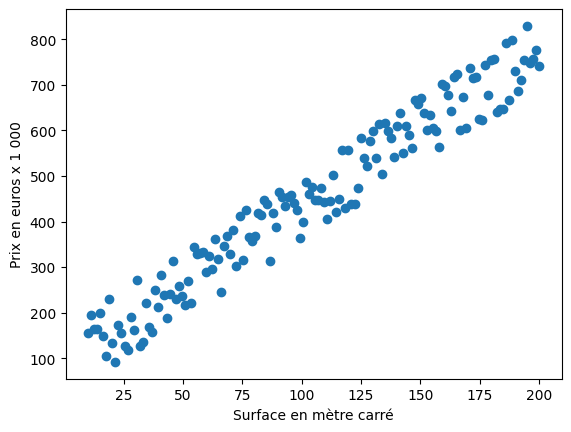

In [ ]:
# =========== CELLULE DE CHARGEMENT DES DONNÉES : Éxecutez la cellule sans y toucher =======

# Le vrai jeu de données
dataset,labels = dataset_house()
plt.scatter(dataset,labels)
plt.xlabel("Surface en mètre carré")
plt.ylabel("Prix en euros x 1 000")

Vous allez maintenant pouvoir tester votre modèle sur un le jeu de données !  
Complétez la fonction test_model :  
Elle prend en entrée un jeu de données, les réponses associées et des poids $\theta_0$ et $\theta_1$ et renvoie l'erreur totale du modèle si on utilise ces poids. (Utilisez les fonctions que vous avez codées jusqu'à présent)

Vous devez utiliser forward pour calculer les prédictions du modèle, puis calculer le cout moyen sur tout le jeu de données

In [ ]:
def test_model(dataset, labels, theta):
  return mse_for_all_dataset(forward(dataset,theta), labels)

dataset = add_one_to_dataset(np.array(dataset))
labels = np.array(labels)

test_model(dataset, labels, np.ones(2))

141961.21173406288

Créez une fonction qui s’appelle affiche_dataset_et_modele, qui prend en entrée le jeu de données, les labels et un vecteur theta.  Elle affiche les points du jeu de données et la courbe de prédiction

In [ ]:
def affiche_dataset_et_modele(dataset, labels, theta):
  x = np.linspace(np.min(dataset[:,1]),np.max(dataset[:,1]), len(labels))
  y_hat = forward(dataset, theta)
  plt.scatter(dataset[:,1],labels)
  plt.plot(x, y_hat, color='red')
  plt.show()


Testez différentes valeurs de $\theta_0$ et $\theta_1$ (Utilisez la fonction d'avant pour afficher le jeu de données et le modèle, vous pouvez également afficher le score de votre modèle avec test_model

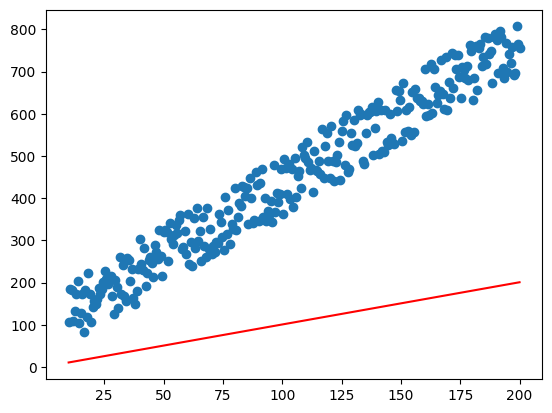

In [ ]:
# Ici utilisez affiche_dataset_et_modele pour voir si votre modèle est bon
affiche_dataset_et_modele(dataset, labels, np.ones(2))

# pas de assert, vérifiez juste visuellement
# Changez ensuite les poids pour voir si vous vous approchez ou non !

Maintenant, nous allons voir comment ajuster les poids $\theta$ en fonction des erreurs que commet le modèle.

La fonction objectif est la suivante :

$$\min_\theta \sum_{i=0}^{n} = || y^{(i)} - f_{\theta}(x^{(i)}) ||^2$$

Rappel de l'équation de mis à jour des poids de la regression linéaire :  
$\theta_i' = \theta_i - \alpha \times \frac{\partial}{\partial \theta_i}J(\theta_0,\theta_1)$  

$\theta_i'$ est le nouveau poids i de la régression linéaire  
$\theta_i$ est l'ancien poids i de la régression linéaire  
$\alpha$ est le constante que l'on va appeler "taux d'apprentissage" ou "learning rate". Pour le moment, mettez comme valeur par défaut 0.0001, mais vous pourrez tester ensuite d’autres valeurs et voir comment cela impacte votre modèle.  
$\frac{\partial}{\partial \theta_i}J(\theta_0,\theta_1)$ correspond à la dérivée de la fonction de coût en fonction de $\theta_i$ C'est à dire, dans quelle direction il faut ajuster $\theta_i$ pour diminuer le cout total du modèle.

Le gradient s’écrit comme ceci :
$$\begin{bmatrix} \frac{\partial}{\partial \theta_0} J(\theta), & \frac{\partial}{\partial \theta_1} J(\theta) & \cdots & \frac{\partial}{\partial \theta_n} J(\theta) \end{bmatrix}$$

Et se calcule comme ça :

$$\begin{bmatrix}
\frac{\partial}{\partial \theta_0} \\
\frac{\partial}{\partial \theta_1} \\
\cdots \\
\frac{\partial}{\partial \theta_n}
\end{bmatrix}=\begin{bmatrix}
\frac{1}{n} \sum_{j=1}^n [ (h_{\theta}(x^{(j)}) - y^{(j)})\times x_0^{(j)} ] \\
\frac{1}{n} \sum_{j=1}^n [(h_{\theta}(x^{(j)}) - y^{(j)})\times x_1^{(j)} ] \\
\frac{1}{n} \sum_{j=1}^n [ (h_{\theta}(x^{(j)}) - y^{(j)})\times x_n^{(j)} ]
\end{bmatrix} $$

Essayez de vectoriser le calcul

In [ ]:
def grad_theta(dataset, labels, theta):
  #h_theta = np.dot(X, theta)

  # Erreurs
  #e = h_theta - y

  # Gradient
  #gradient = (1/len(y)) * np.dot(e.T, X)
  #return gradient
  n_example = dataset.shape[0]
  err = forward(dataset, theta) - labels
  grad = err.dot(dataset) / n_example
  return grad

In [ ]:
## Test du gradient en fonction de theta
dataset_test = add_one_to_dataset(np.array([[1],[2]]))
labels_test = np.array([1,2])
theta = np.array([0.1,0.1])

true_grad = [-1.25, -2.1]
rep = grad_theta(dataset_test, labels_test, theta)

assert np.all(rep == true_grad), f"Gradient faux, votre gradient {rep}, vrai gradient {true_grad}"
print("Fonction gradient ok!")

Fonction gradient ok!


Maintenant que vous avez des fonctions qui calculent les dérivées du cout en fonction des poids, la fonction gradient_descent_step va faire la mise à jour de $\theta$. Pour cela utilisez l'équation suivante :

$\theta_i' = \theta_i - \alpha \times \frac{\partial}{\partial \theta_i}J(\theta_0,\theta_1)$  

Attention, la mise à jour des poids doit se faire en simultané. C'est à dire que vous calculez les dérivées avec les anciens poids $\theta$ et une fois calculées, vous utilisez les dérivées pour mettre à jour vos poids.

La fonction prend en entrée le jeu de données, les réponses associées, les poids, ainsi que le pas d'apprentissage (commencez avec 1e-5) et elle retourne les nouveaux poids $\theta_0$ et $\theta_1$

Vous pouvez afficher l’erreur mse à chaque étape pour voir si elle diminue bien (elle devrait diminuer à chaque itération)

In [ ]:
def gradient_descent_step(dataset, labels, theta, pas):
  gradient_new = pas*grad_theta(dataset, labels, theta)
  new_theta = theta - gradient_new
  return new_theta

dataset_test = add_one_to_dataset(np.array([[1],[2]]))
labels_test = np.array([1,2])
theta = np.array([0.1,0.1])
gradient_descent_step(dataset_test, labels_test, theta, 0.01)


array([0.1125, 0.121 ])

In [ ]:
def train(X, y, theta, num_update, verbose, learning_rate):
  for i in range(num_update):
    #print(mse_for_all_dataset(labels, dataset))
    theta = gradient_descent_step(X, y, theta, learning_rate)
    #print(theta)

  return theta

In [ ]:
def train(dataset, labels, init_theta, num_update=20000, verbose=10000, learning_rate=1e-4):
  print("Erreur initiale :", test_model(dataset, labels, init_theta))
  for i in range(num_update):
    new_theta -= learning_rate * grad_theta(dataset, labels, new_theta)
    if verbose:
      if not i%verbose:
        print("Erreur à l'étape {} : {:.0f}".format(i,test_model(dataset, labels, new_theta)))
        print(new_theta)
  return new_theta

Le calcul devrait aller relativement vite!
(Moins de 2s pour faire toutes les étapes)

In [ ]:
dataset, labels = dataset_house(300)
dataset = add_one_to_dataset(dataset)

init_theta = np.random.random(dataset.shape[1])

# Adaptez la fonction train ici en fonction de vos paramètres.
new_w = train(dataset, labels, init_theta, num_update=20000, verbose=10000, learning_rate=1e-4)
print("Erreur finale : {:.1f}".format(test_model(dataset,labels,new_w)))

Le flux de sortie a été tronqué et ne contient que les 5000 dernières lignes.
[23.18951942  3.91835273]
[23.19081099  3.91834308]
[23.19210253  3.91833343]
[23.19339404  3.91832378]
[23.19468553  3.91831413]
[23.19597699  3.91830448]
[23.19726842  3.91829483]
[23.19855982  3.91828518]
[23.19985119  3.91827553]
[23.20114254  3.91826589]
[23.20243386  3.91825624]
[23.20372515  3.91824659]
[23.20501641  3.91823694]
[23.20630765  3.91822729]
[23.20759886  3.91821765]
[23.20889004  3.918208  ]
[23.21018119  3.91819835]
[23.21147231  3.91818871]
[23.21276341  3.91817906]
[23.21405448  3.91816941]
[23.21534552  3.91815977]
[23.21663653  3.91815012]
[23.21792751  3.91814048]
[23.21921847  3.91813083]
[23.2205094   3.91812118]
[23.2218003   3.91811154]
[23.22309117  3.91810189]
[23.22438202  3.91809225]
[23.22567284  3.91808261]
[23.22696363  3.91807296]
[23.22825439  3.91806332]
[23.22954512  3.91805367]
[23.23083583  3.91804403]
[23.23212651  3.91803439]
[23.23341716  3.91802474]
[23.23470778

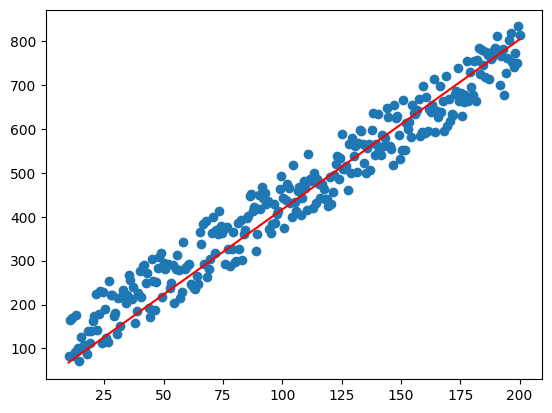

In [ ]:
affiche_dataset_et_modele(dataset,labels, new_w)

Si vous êtes arrivés jusque là, vous avez construit votre premier modèle linéaire avec numpy.

### Vérification que vos fonctions machent dans le cas général

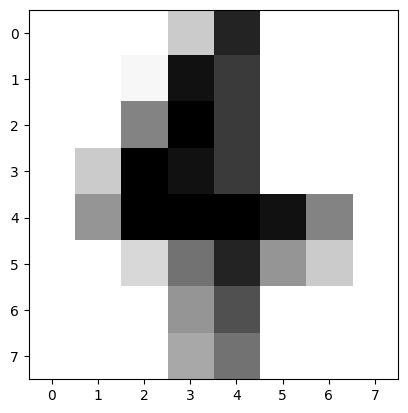

In [ ]:
dataset, labels, exemples = chargement_chiffre(9)
dataset = add_one_to_dataset(dataset)
plt.imshow(exemples[130], cmap="Greys") # C’est normalement un 4

In [ ]:
init_theta = np.random.random(65)
new_theta = train(dataset, labels, init_theta, num_update=200000, verbose=10000, learning_rate=2e-4)
print("Erreur finale : {:.1f}".format(test_model(dataset,labels,new_theta)))

Streaming output truncated to the last 5000 lines.
  1.39490343e-02]
[ 1.45107859e+00  5.84442137e-01  1.14196880e-01  2.05326579e-02
 -6.52491974e-02  8.58445804e-02  2.26788935e-02 -1.87393624e-02
  1.05637731e-02  5.42874426e-01 -3.75086726e-02  1.01463842e-01
  4.72485111e-02 -5.43628610e-02 -4.80508380e-02  7.68681139e-02
  2.15010472e-01  5.61377738e-01  2.47752389e-02  1.25809278e-02
 -4.59316527e-02 -8.53907975e-02 -2.26763859e-02 -4.51311909e-02
 -1.96096055e-01  3.72535692e-01 -9.55661363e-02  3.68464642e-02
  5.65755722e-02  6.89552169e-02  5.72682454e-02 -3.25026746e-02
  1.76540969e-01  7.00060818e-01 -1.02225770e-01 -1.28914052e-03
  9.74594172e-02  5.31249873e-02  3.90903544e-02 -3.45534341e-02
  3.80897211e-01  1.53053537e-01  3.16037380e-02  7.73882493e-02
  1.46163772e-02  1.29226520e-01  3.64466422e-02  5.78100853e-03
  2.19903439e-01  3.92438525e-01  3.77886368e-03  2.38546136e-02
 -4.84793976e-02 -1.75883167e-01  5.14601116e-03  7.55033583e-02
 -1.52635837e-01  6.0

Votre réponse : 4 (Arrondit de 4.214648056405312)
Vraie réponse : 4

Image:


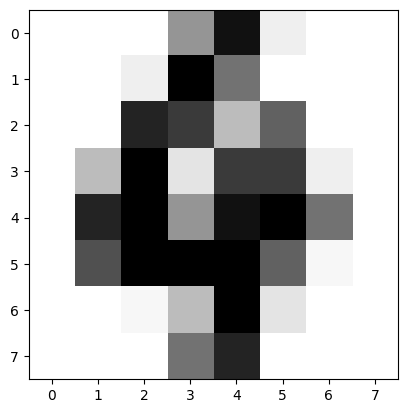

In [ ]:
random_img = np.random.randint(len(dataset))
prediction = forward(dataset[random_img,:],new_theta)

print("Votre réponse : {} (Arrondit de {})\nVraie réponse : {}\n\nImage:".format(int(round(prediction)), prediction, labels[random_img]))
plt.imshow(exemples[random_img], cmap="Greys")

Il fait encore beaucoup d'erreur, c'est normal, on vient d’utiliser un modèle linéaire qui fait de la régression sur une tâche de classification, et on ne tient pas compte du tout de la structure de l’image.

## Utilisation de sklearn sur un jeu de données

Nous allons utiliser sklearn pour pouvoir faire notre régression linéaire. Nous allons également tester deux améliorations que nous avons vu en cours : L’ajout de features polynomial et la régularisation.

In [ ]:
from sklearn.datasets import load_diabetes
from sklearn.linear_model import LinearRegression, Ridge
from sklearn.pipeline import make_pipeline
from sklearn.preprocessing import PolynomialFeatures
from sklearn.metrics import mean_squared_error

import numpy as np

Chargement des données (ne pas modifier)

In [ ]:
# Loading diabetes data
X, y = load_diabetes(return_X_y=True)

n_example = y.shape[0]
print(n_example)

percent_train = 0.8

print(X[:5, :])

442
[[ 0.03807591  0.05068012  0.06169621  0.02187239 -0.0442235  -0.03482076
  -0.04340085 -0.00259226  0.01990749 -0.01764613]
 [-0.00188202 -0.04464164 -0.05147406 -0.02632753 -0.00844872 -0.01916334
   0.07441156 -0.03949338 -0.06833155 -0.09220405]
 [ 0.08529891  0.05068012  0.04445121 -0.00567042 -0.04559945 -0.03419447
  -0.03235593 -0.00259226  0.00286131 -0.02593034]
 [-0.08906294 -0.04464164 -0.01159501 -0.03665608  0.01219057  0.02499059
  -0.03603757  0.03430886  0.02268774 -0.00936191]
 [ 0.00538306 -0.04464164 -0.03638469  0.02187239  0.00393485  0.01559614
   0.00814208 -0.00259226 -0.03198764 -0.04664087]]


Dans la cellule suivante, vous allez faire en sorte de repartir les données entrain un set d’entraînement et un set de test
(avec une répartition à 80% dans votre jeu d’entraînement et 20% dans le test)

Ça va devoir devenir un réflexe si le split train/test n’a pas déjà été fait : on vérifie si un modèle généralise bien, pas si il a réussi à apprendre le jeu d’entraînement par coeur!

(353, 10) (353,)
(89, 10) (89,)


Maintenant, vous allez pouvoir utiliser l’objet LinearRegression pour faire l’apprentissage sur le jeu de données d’entraînement. Affichez ensuite le score mean_square_error sur le jeu de données d’entraînement et sur le jeu de données de test.

For Linear Regression : Train Score 2828.682703517912 Test Score 3079.968330917685


Que se passe t’il si dans mon jeu de données, il y a pleins de colonnes qui n’apporte pas d’informations sur mon jeu de donnée ?
Pour connaître la réponse à cette question, créez une fonction **add_random_features** qui prend entrée un jeu de données et un nombre de colonne, et qui ajoute autant de colonne de bruit (chaque colonne doit être aléatoire) qu’indiqué en paramètres.

Maintenant, essayer d’ajouter 1, puis 5, puis 10, puis 100, puis 200 colonnes de bruit.
Que constatez-vous sur l’évolution du score en train et en test ?

(353, 10) (353, 1)
(89, 10) (89, 1)
For 1 random columns : Train Score 2814.022224985322 Test Score 3043.880879715457
(353, 10) (353, 5)
(89, 10) (89, 5)
For 5 random columns : Train Score 2815.9812108840306 Test Score 3158.7680230265773
(353, 10) (353, 10)
(89, 10) (89, 10)
For 10 random columns : Train Score 2757.7103684396457 Test Score 3233.685432702276
(353, 10) (353, 100)
(89, 10) (89, 100)
For 100 random columns : Train Score 2061.487714240314 Test Score 4261.650742086281
(353, 10) (353, 200)
(89, 10) (89, 200)
For 200 random columns : Train Score 1071.5648773278608 Test Score 7835.393525007288


Passons à la regression polynomial, utilisez l’objet PolynomialFeatures pour créer pleins de colonnes contenant le carré (et éventuellement plus) des caractéristiques.  
Vous pouvez utiliser pour cela "make_pipeline" qui permet de créer un pipeline de transformation, celui-ci va contenir une instance de PolynomialFeatures et une instance de LinearRegression.

https://scikit-learn.org/stable/modules/generated/sklearn.pipeline.Pipeline.html

Augmentez le degré du polynome (vous pouvez tester 2,3 et 4), que constatez-vous ?

For 2 polynomial features : Train Score 2335.9014218823427 Test Score 3605.541035963263
For 3 polynomial features : Train Score 2283.501416430595 Test Score 194975.60674157302
For 4 polynomial features : Train Score 3.8962121756791006e-22 Test Score 288681.83357614727


On a vu dans le cours le moyen de faire de la régression linéaire avec de la régularization. L’idée est de forcer que certaines caractéristiques soit à 0 à la fin du processus d’entraînement (et donc d’ignorer certaines caractéristiques qui ont l’air de ne pas servir)

La fonction objectif devient donc :

$$\min_\theta \sum_{i=0}^{n} = || y^{(i)} - f_{\theta}(x^{(i)}) ||^2 + \color{red}{\lambda ||\theta||^2}$$

Dans sklearn, la régression + la régularisation L2 s’appelle Ridge.
Elle prend en entrée un paramètre alpha qui va "équilibrer" le coût entre la tâche de regression et le fait de mettre les poids à zéros.

Relancez l’apprentissage de ce jeu de données (avec les features polynomial) avec une Ridge, et essayez différentes valeurs de alpha, que constatez-vous ?
(Essayez avec les valeurs [1e-3, 1e-2 et 1e-1])

3088.269827885422
For 2 polynomial features, alpha = 0.001 : Train Score 2499.9047274131653 Test Score 3088.269827885422
3107.3799208624155
For 3 polynomial features, alpha = 0.001 : Train Score 2483.1613604768054 Test Score 3107.3799208624155
3108.029843916414
For 4 polynomial features, alpha = 0.001 : Train Score 2482.507622483879 Test Score 3108.029843916414
3044.59297081314
For 2 polynomial features, alpha = 0.01 : Train Score 2689.498895487915 Test Score 3044.59297081314
3046.005908156724
For 3 polynomial features, alpha = 0.01 : Train Score 2686.9465765922155 Test Score 3046.005908156724
3046.0524368774595
For 4 polynomial features, alpha = 0.01 : Train Score 2686.842537926624 Test Score 3046.0524368774595
3106.164544921576
For 2 polynomial features, alpha = 0.1 : Train Score 2833.7497064916347 Test Score 3106.164544921576
3106.3104161141937
For 3 polynomial features, alpha = 0.1 : Train Score 2833.432521140182 Test Score 3106.3104161141937
3106.3122567355185
For 4 polynomial fea

Testez maintenant la Ridge sur les jeu de données avec les différents niveau de colonnes de bruit, que constatez-vous ?

(353, 10) (353, 1)
(89, 10) (89, 1)
For 1 random columns : Train Score 2836.649823783453 Test Score 3100.2443843969454
(353, 10) (353, 5)
(89, 10) (89, 5)
For 5 random columns : Train Score 2792.7885237295754 Test Score 3136.677637664088
(353, 10) (353, 10)
(89, 10) (89, 10)
For 10 random columns : Train Score 2758.9617828684227 Test Score 3154.797236818462
(353, 10) (353, 100)
(89, 10) (89, 100)
For 100 random columns : Train Score 1777.0115753556045 Test Score 4751.402495333184
(353, 10) (353, 200)
(89, 10) (89, 200)
For 200 random columns : Train Score 1136.7175671464256 Test Score 7523.583844251638
